#  Country Clustering
We can measure how similar two Wikipedia readerships are by looking at the spearman correlation between the pageviews for the wikidata items they have in common.

#### Load and Prepare Data

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from ConfigParser import SafeConfigParser
from operator import add
from pyspark.mllib.recommendation import ALS, Rating
import random 
from random import randint
import itertools
from math import sqrt
import numpy as np
from pprint import pprint
import math
from ConfigParser import SafeConfigParser
import pandas as pd
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
from scipy.cluster.hierarchy import linkage, dendrogram

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
config = '/home/ellery/wikimedia/missing_articles/missing_articles.ini'
cp = SafeConfigParser()
cp.read(config)
languages = ['ar', 'bg', 'ca', 'ceb', 'cs','da','de','el','en','eo','es','et','eu','fa','fi','fr','gl','he','hi','hr','hu','hy','id','it','ja','kk','ko','lt','ms','nl','nn','no','pl','pt','ro','ru','sh','simple','sk','sl','sr','sv','tr','uk','uz','vi','war','zh','min','vo']
languages_set = set(languages)

In [6]:
def get_parser(names):
    def loadRecord(line):
        cells = line.strip().split('\t')
        return dict(zip(names, cells))
    return loadRecord

names = [ 'id', 'lang', 'title', 'pageview_count']
pageviews = sc.textFile(cp.get('general', 'pageviews'))\
.map(get_parser(names))\
.filter(lambda x: len(x) == 4)\
.filter(lambda x: x['lang'] in languages_set)\
.map(lambda x: (x['lang'], (int(x['id'][1:]), float(x['pageview_count']))))\
.groupByKey().collect()

In [7]:
lang2df = {}
for x in pageviews:
    lang = x[0]
    data = list(x[1])
    index = [t[0] for t in data]
    views = [t[1] for t in data]
    lang2df[lang] = pd.Series(views, index = index)

In [49]:
n = len(languages)
dist_list = []
for i in range(n):
    for j in range(i+1,n):
        pair_df = pd.concat([lang2df[languages[i]], lang2df[languages[j]]], axis=1, join='inner')
        sr = spearmanr(pair_df[0], pair_df[1])[0]
        dist_list.append(1-sr) 

#### Hierarchical Clustering of Wikis

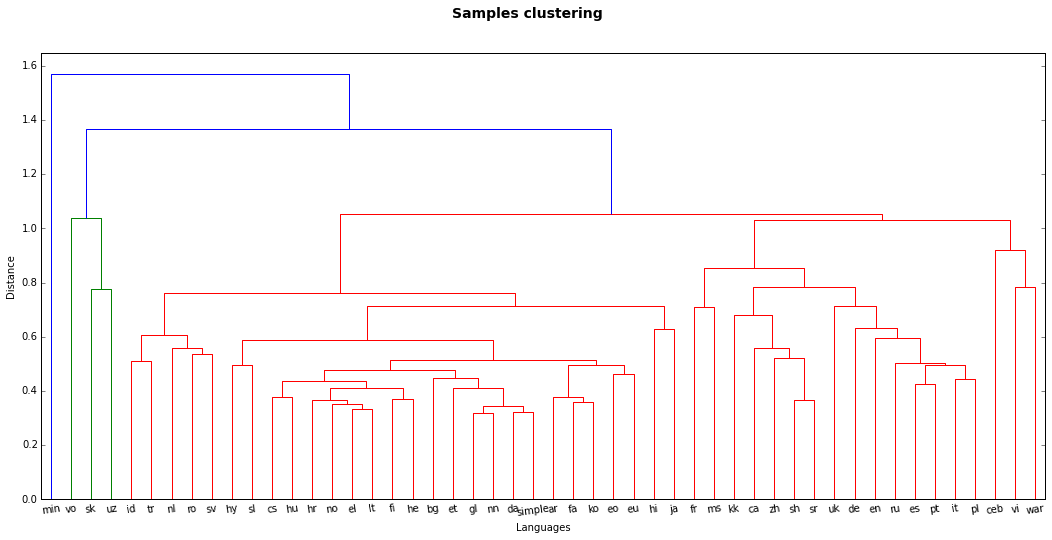

In [71]:
dist_matrix = squareform(dist_list)
data_link = linkage(dist_matrix, method = 'weighted') # computing the linkage
fig = plt.figure(figsize=(18,8))
dendrogram(data_link,labels=languages)
plt.xlabel('Languages')
plt.ylabel('Distance')
plt.suptitle('Samples clustering', fontweight='bold', fontsize=14);

#### Heat Map of Spearman Correlations Ordered by Clustering

<matplotlib.colorbar.Colorbar instance at 0x7fae65b77c68>

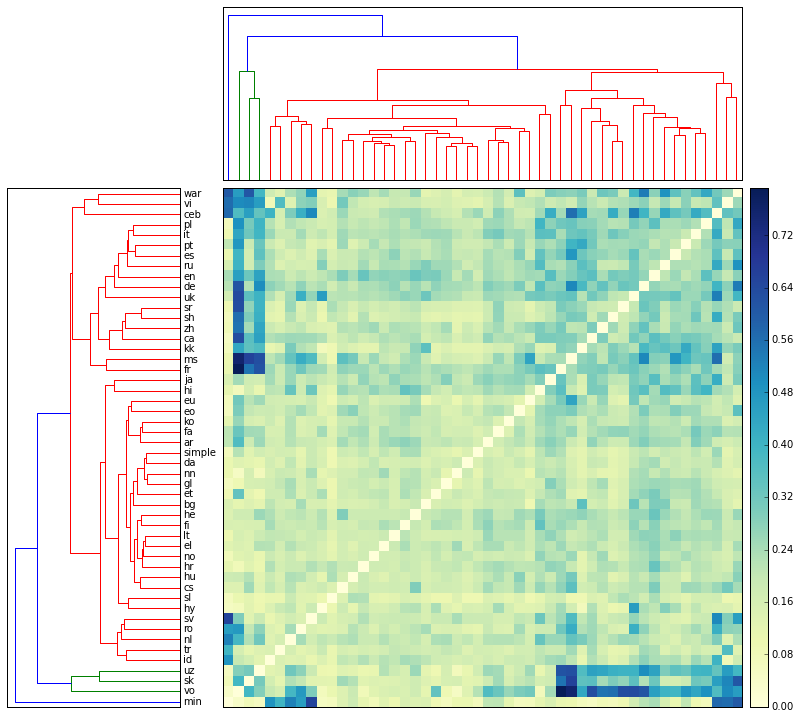

In [74]:
# Compute and plot first dendrogram.
fig = plt.figure(figsize=(12,12))
# x ywidth height
ax1 = fig.add_axes([0.05,0.1,0.2,0.6])
Y = linkage(dist_matrix, method='weighted')
Z1 = dendrogram(Y, orientation='right',labels=languages) # adding/removing the axes
ax1.set_xticks([])

# Compute and plot second dendrogram.
ax2 = fig.add_axes([0.3,0.71,0.6,0.2])
Z2 = dendrogram(Y)
ax2.set_xticks([])
ax2.set_yticks([])

#Compute and plot the heatmap
axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])
idx1 = Z1['leaves']
idx2 = Z2['leaves']
D = dist_matrix
D = D[idx1,:]
D = D[:,idx2]
im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=plt.cm.YlGnBu)
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Plot colorbar.
axcolor = fig.add_axes([0.91,0.1,0.02,0.6])
plt.colorbar(im, cax=axcolor)

#### Simple Heatmap without clustering

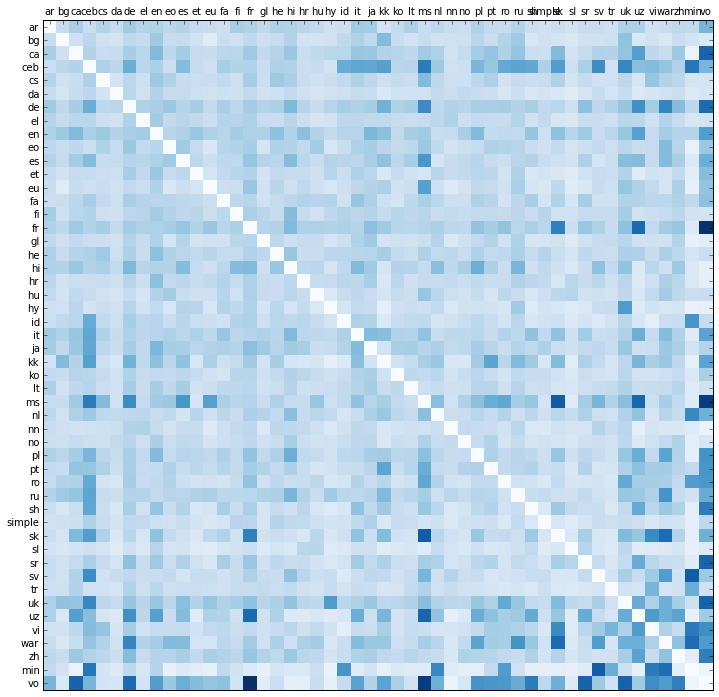

In [66]:
import matplotlib.pyplot as plt
import numpy as np
column_labels = languages
row_labels = languages
data = dist_matrix

fig, ax = plt.subplots(figsize=(12,12))
heatmap = ax.pcolor(data, cmap=plt.cm.Blues)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(data.shape[0])+0.5, minor=False)
ax.set_yticks(np.arange(data.shape[1])+0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(column_labels, minor=False)
plt.show()